In [250]:
from cmath import cos
from math import radians, sin, cos, pi
import os, os.path
from re import L
from statistics import mean
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils import *
from emgFeatures import rms
from scipy.signal import butter, lfilter
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [251]:
def addTorque(angle,fs):

    b, a = butter(4,2,fs=fs,btype='low',analog=False)

    angle = lfilter(b, a, angle)
    rad_angle = np.radians(angle)

    speed = np.gradient(rad_angle,1/fs)
    acel = np.gradient(speed,1/fs)

    speed = lfilter(b, a, speed)
    acel = lfilter(b, a, acel)

    arm_weight = 0.023*74

    torque = (arm_weight*0.129**2 + ((1/3)*arm_weight*0.3**2))*acel + arm_weight*9.81*0.129*np.sin(rad_angle)

    return torque

In [252]:
def filterEMG(data, cfl, cfh, fs):

    bl, al = butter(4, cfl, fs=fs, btype='low', analog=False)
    bh, ah = butter(4, cfh, fs=fs, btype='high', analog=False)

    filtered_data = lfilter(bl,al,data,axis=0)
    filtered_data = lfilter(bh,ah,filtered_data,axis=0)

    return filtered_data

In [253]:
def filter(data, cf, fs):

    b, a = butter(4, cf, fs=fs, btype='low', analog=False)

    filtered_data = lfilter(b,a,data,axis=0)

    return filtered_data

In [254]:
path = 'D:\Documentos\Datasets\Grabaciones 5\subject 1'

data = pd.read_csv(path + '/' + "1_flex_ISO50_12800.txt", sep='\t', header=None).values
data1 = pd.read_csv(path + '/' + "1_flex_75_21600.txt", sep='\t', header=None).values
data2 = pd.read_csv(path + '/' + "1_ext_50_12800.txt", sep='\t', header=None).values
data3 = pd.read_csv(path + '/' + "1_ext_0_0.txt", sep='\t', header=None).values

In [255]:
data = np.concatenate((data1,data2,data1,data2),axis=0)

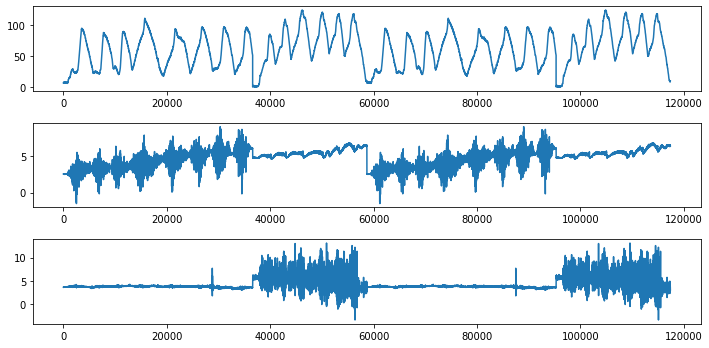

In [256]:
fig, axs = plt.subplots(3, figsize=(10,5))
fig.tight_layout()

axs[0].plot(data[:,4])
axs[1].plot(data[:,0])
axs[2].plot(data[:,1])

In [257]:
angle = data[:,4]
emg = data[:,0:2]
torque = addTorque(data[:,4], 1024)

In [258]:
femg = filterEMG(emg,500,5,1024)
angle = angle[100:]
femg = femg[100:,:]

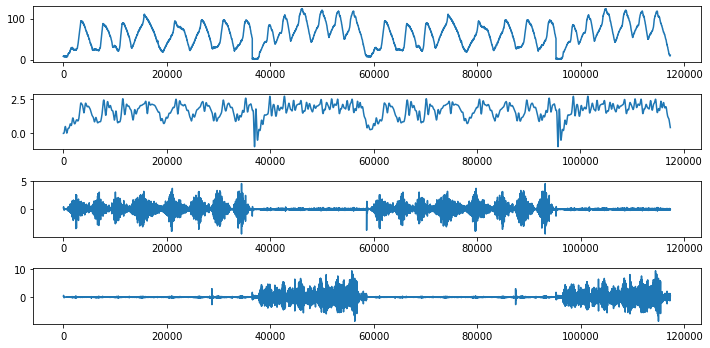

In [259]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

axs[0].plot(angle)
axs[1].plot(torque)
axs[2].plot(femg[:,0])
axs[3].plot(femg[:,1])

In [260]:
w = 200
w_inc = 100
len_data = femg.shape[0]
emg_data = []
angle2 = []
torque2 = []
for i in range(0,len_data - w + 1,w_inc):

    d = femg[i:i + w,:]
    d1 = angle[i + w - 1]
    d2 = torque[i + w - 1]
    emg_data.append(d)
    angle2.append(d1)
    torque2.append(d2)

In [261]:
f_emg_data = EMGRMS(emg_data)

print(f_emg_data.shape)

(1171, 2)


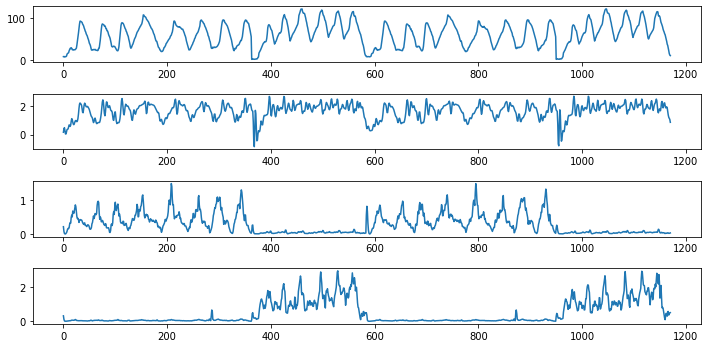

In [262]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

pemg = np.vstack(f_emg_data)
pangle = np.vstack(angle2)
ptorque = np.vstack(torque2)

axs[0].plot(pangle)
axs[1].plot(ptorque)
axs[2].plot(pemg[:,0])
axs[3].plot(pemg[:,1])

In [263]:
f_emg_data = filter(f_emg_data, 2, 1/0.05)

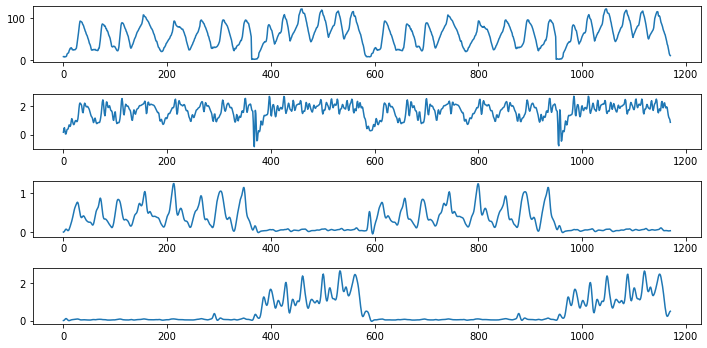

In [264]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

pemg = np.vstack(f_emg_data)

axs[0].plot(pangle)
axs[1].plot(ptorque)
axs[2].plot(pemg[:,0])
axs[3].plot(pemg[:,1])

In [265]:
sc = MinMaxScaler()
ptorque = sc.fit_transform(ptorque)
f_emg_data = sc.fit_transform(f_emg_data)[:,0:2]

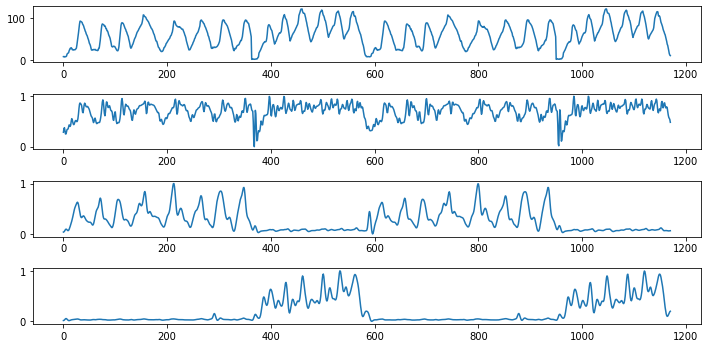

In [266]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

pemg = np.vstack(f_emg_data)

axs[0].plot(pangle)
axs[1].plot(ptorque)
axs[2].plot(pemg[:,0])
axs[3].plot(pemg[:,1])

In [267]:
X_train, X_test, Y_train, Y_test = train_test_split(f_emg_data, ptorque, test_size=0.2, shuffle=False)

In [268]:
lr = RandomForestRegressor()
lr.fit(X_train,Y_train)

C:\Users\alejo\AppData\Local\Temp\ipykernel_17840\2897327801.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  lr.fit(X_train,Y_train)


RandomForestRegressor()

Train R2 =  0.6111252834491752
Train MAE =  0.05946107446026555


Text(0.5, 0, 'Ventana')

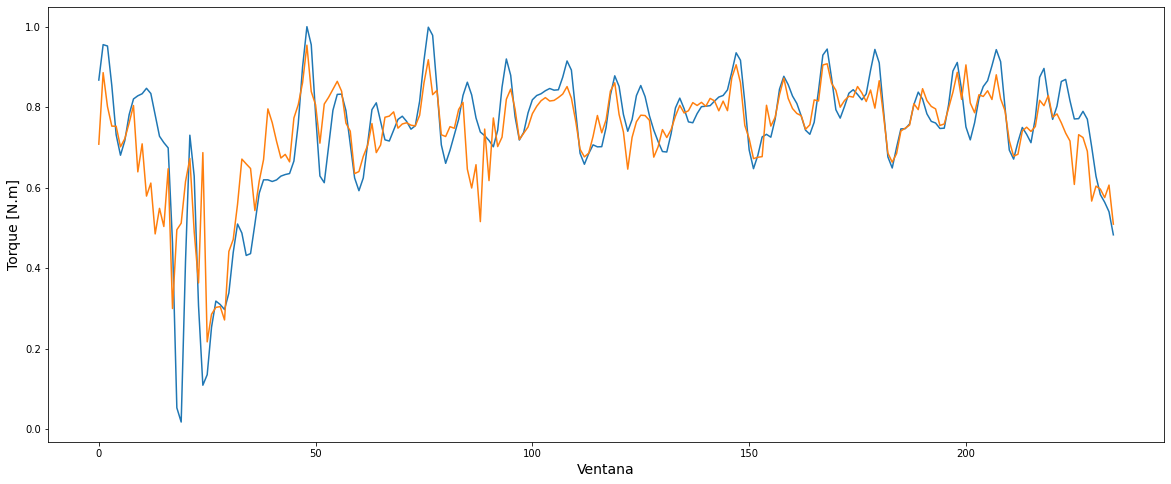

In [269]:
predicted = lr.predict(X_test)
#predicted = filter(predicted,8,1/0.05)
print("Train R2 = ", r2_score(Y_test, predicted))
print("Train MAE = ", mean_absolute_error(Y_test, predicted))

plt.figure(figsize=(20,8))
plt.plot(Y_test)
plt.plot(predicted)
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)